In [10]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.weightstats import ztest as ztest
warnings.filterwarnings('ignore')
participant = '2022_30b'
root_path = '/workspaces/Tracking-Gazes-on-Museum-Pieces-Data-Plus/data'

In [11]:
orig_df = pd.read_csv(f'{root_path}/{participant}/gaze.csv')
display(orig_df.head())

"""
Pre-processing
"""
orig_df['shifted_timestamp'] = orig_df['timestamp [ns]'].shift(-1)
orig_df['row_duration'] = (orig_df['shifted_timestamp'] - orig_df['timestamp [ns]'])/1e6
orig_df['saccade id'] = None
for index, row in orig_df.iterrows():
    if index == 0:
        continue
    
    if row['fixation id'] != row['fixation id']: #NaN for missing values
        # get prev fixation id value
        if orig_df['fixation id'][index-1] == orig_df['fixation id'][index-1]:
            orig_df.loc[index, 'saccade id'] = orig_df['fixation id'][index-1]
        else:
            orig_df.loc[index, 'saccade id'] = orig_df['saccade id'][index-1]

display(orig_df.head())

,section id,recording id,timestamp [ns],gaze x [px],gaze y [px],worn,fixation id,blink id
0,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382054298234,782.720,486.945,1.0,NaN,NaN
1,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382058354234,783.631,486.954,1.0,NaN,NaN
2,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382066289234,782.818,488.635,1.0,NaN,NaN
3,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382070307234,782.930,490.364,1.0,NaN,NaN
4,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382074355234,782.943,491.291,1.0,NaN,NaN


,section id,recording id,timestamp [ns],gaze x [px],gaze y [px],worn,fixation id,blink id,shifted_timestamp,row_duration,saccade id
0,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382054298234,782.720,486.945,1.0,NaN,NaN,1.649843e+18,4.056064,None
1,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382058354234,783.631,486.954,1.0,NaN,NaN,1.649843e+18,7.934976,None
2,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382066289234,782.818,488.635,1.0,NaN,NaN,1.649843e+18,4.018176,None
3,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382070307234,782.930,490.364,1.0,NaN,NaN,1.649843e+18,4.047872,None
4,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,1649843382074355234,782.943,491.291,1.0,NaN,NaN,1.649843e+18,3.942144,None


In [12]:
updated_df = pd.read_csv(f'{root_path}/{participant}/updated_gaze_{participant}.csv')
display(updated_df.head())

"""
Pre-processing
"""
updated_df['shifted_timestamp'] = updated_df['timestamp [ns]'].shift(-1)
updated_df['row_duration'] = (updated_df['shifted_timestamp'] - updated_df['timestamp [ns]'])
updated_df['saccade id'] = None

for index, row in updated_df.iterrows():
    if index == 0:
        continue
    
    if row['fixation id'] != row['fixation id']: #NaN for missing values
        # get prev fixation id value
        if updated_df['fixation id'][index-1] == updated_df['fixation id'][index-1]:
            updated_df.loc[index, 'saccade id'] = updated_df['fixation id'][index-1]
        else:
            updated_df.loc[index, 'saccade id'] = updated_df['saccade id'][index-1]

display(updated_df.head())

,index,section id,recording id,timestamp [ns],gaze x [px],gaze y [px],worn,fixation id,blink id,ref_center_x,ref_center_y
0,582,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,2939.309,606.297,371.578,1.0,10.0,NaN,582,372
1,591,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,2983.381,622.193,368.030,1.0,10.0,NaN,598,367
2,597,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,3015.760,587.289,359.858,1.0,11.0,NaN,563,359
3,604,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,3051.376,598.201,361.980,1.0,11.0,NaN,574,361
4,611,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,3083.415,630.254,346.717,1.0,11.0,NaN,606,346


,index,section id,recording id,timestamp [ns],gaze x [px],gaze y [px],worn,fixation id,blink id,ref_center_x,ref_center_y,shifted_timestamp,row_duration,saccade id
0,582,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,2939.309,606.297,371.578,1.0,10.0,NaN,582,372,2983.381,44.072,None
1,591,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,2983.381,622.193,368.030,1.0,10.0,NaN,598,367,3015.760,32.379,None
2,597,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,3015.760,587.289,359.858,1.0,11.0,NaN,563,359,3051.376,35.616,None
3,604,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,3051.376,598.201,361.980,1.0,11.0,NaN,574,361,3083.415,32.039,None
4,611,8bef8eba-8d93-43bb-bd60-4213cc733501,5146df65-fb40-4696-82e6-199926c4a93d,3083.415,630.254,346.717,1.0,11.0,NaN,606,346,3111.353,27.938,None


In [14]:
updated_df['ref_x_pixel_diff'] = updated_df['ref_center_x'] - updated_df['gaze x [px]']
updated_df['ref_y_pixel_diff'] = updated_df['ref_center_y'] - updated_df['gaze y [px]']

updated_df[['ref_x_pixel_diff', 'ref_y_pixel_diff']].describe()

,ref_x_pixel_diff,ref_y_pixel_diff
count,1807.000000,1807.000000
mean,-14.824228,-20.988793
std,39.279749,29.997135
min,-681.209000,-376.755000
25%,-20.923500,-31.999000
50%,-11.993000,-23.776000
75%,-4.681000,-10.783000
max,139.404000,559.493000


In [15]:
"""
Basic Analysis
"""
print('################### Original Data ###############################')
print(f'Average row (data capture) duration - {orig_df["row_duration"].mean():.3f} (ms)')
print(f'Total number of fixations - {orig_df["fixation id"].nunique()}')
print(f'Total number of saccades - {orig_df["saccade id"].nunique()}')


print('################### Updated Data ###############################')
print(f'Average row (data capture) duration - {updated_df["row_duration"].mean():.3f} (ms)')
print(f'Total number of fixations - {updated_df["fixation id"].nunique()}')
print(f'Total number of saccades - {updated_df["saccade id"].nunique()}')

################### Original Data ###############################
Average row (data capture) duration - 5.043 (ms)
Total number of fixations - 196
Total number of saccades - 195
################### Updated Data ###############################
Average row (data capture) duration - 32.587 (ms)
Total number of fixations - 187
Total number of saccades - 166


,count,mean,std,min,25%,50%,75%,max
Original Data fixations durations,196.0,234.651946,212.971408,59.981056,99.515968,161.948416,308.150464,1364.514048


,count,mean,std,min,25%,50%,75%,max
Updated Data fixation durations,187.0,236.43885,214.242471,52.107,99.993,167.925,300.5415,1348.485


Zscore - 0.0, Pval - 1.0


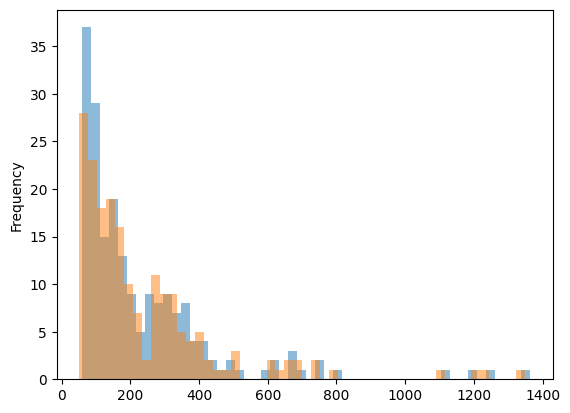

In [16]:
"""
Fixation Analysis - Duration (ms)
"""
orig_fixation = orig_df.groupby('fixation id').sum().reset_index()
orig_fixation = orig_fixation[['fixation id', 'row_duration']]
display(orig_fixation[['row_duration']].describe().rename(columns={"row_duration":'Original Data fixations durations'}).T)
ax = orig_fixation['row_duration'].plot.hist(bins=50, alpha=0.5)

updated_fixation = updated_df.groupby('fixation id').sum().reset_index()
updated_fixation = updated_fixation[['fixation id', 'row_duration']]
display(updated_fixation[['row_duration']].describe().rename(columns={"row_duration":'Updated Data fixation durations'}).T)
ax = updated_fixation['row_duration'].plot.hist(bins=50, alpha=0.5)

zscore, pval = ztest(updated_fixation['row_duration'], orig_fixation['row_duration'], value=abs(updated_fixation['row_duration'].mean() - orig_fixation['row_duration'].mean())) 
print(f'Zscore - {zscore}, Pval - {pval}')

,count,mean,std,min,25%,50%,75%,max
saccades,195.0,79.794788,96.61894,16.084992,24.015104,40.013056,95.827072,688.879872


,count,mean,std,min,25%,50%,75%,max
saccades,166.0,88.183151,97.697286,20.005,32.077,55.991,99.98675,708.886


Zscore - 0.8179070734587988, Pval - 0.413410251021585


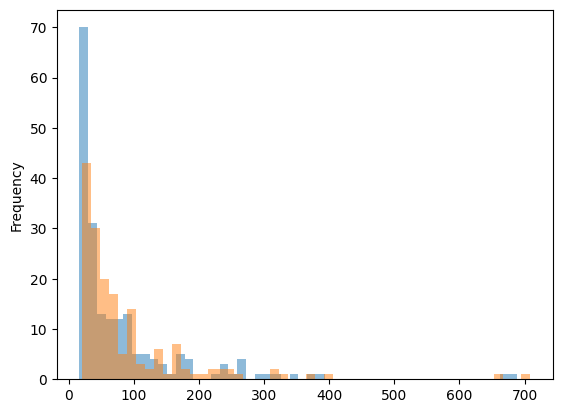

In [17]:
"""
Saccade Analysis - Duration (ms)
"""
orig_saccade = orig_df.groupby('saccade id').sum().reset_index()
orig_saccade = orig_saccade[['saccade id', 'row_duration']]
display(orig_saccade[['row_duration']].describe().rename(columns={"row_duration":'saccades'}).T)
ax = orig_saccade['row_duration'].plot.hist(bins=50, alpha=0.5)

updated_saccade = updated_df.groupby('saccade id').sum().reset_index()
updated_saccade = updated_saccade[['saccade id', 'row_duration']]
display(updated_saccade[['row_duration']].describe().rename(columns={"row_duration":'saccades'}).T)
ax = updated_saccade['row_duration'].plot.hist(bins=50, alpha=0.5)

zscore, pval = ztest(updated_saccade['row_duration'], orig_saccade['row_duration']) 
print(f'Zscore - {zscore}, Pval - {pval}')


In [18]:
"""
Fixation Analysis - Amplitude
"""
def calculate_amplitute(df):
    df.reset_index(drop=True, inplace=True)
    starting_x = df['gaze x [px]'][0]
    starting_y = df['gaze x [px]'][0]
    ending_x = df['gaze x [px]'].iloc[-1]
    ending_y = df['gaze y [px]'].iloc[-1]
    amplitude =  math.dist((starting_x, starting_y), (ending_x, ending_y))
    return pd.DataFrame({"amplitude":[amplitude]})

fixation_amplitude = df.groupby('fixation id').apply(calculate_amplitute).reset_index()
if 'level_1' in fixation_amplitude.columns:
    fixation_amplitude.drop(columns=['level_1'], inplace=True)

display(fixation_amplitude[['amplitude']].describe().T)
ax = fixation_amplitude['amplitude'].plot.hist(bins=50, alpha=0.5)

NameError: name 'df' is not defined

In [19]:
"""
Saccade Analysis - Amplitude
"""
saccade_amplitude = df.groupby('saccade id').apply(calculate_amplitute).reset_index()
if 'level_1' in saccade_amplitude.columns:
    saccade_amplitude.drop(columns=['level_1'], inplace=True)

display(saccade_amplitude[['amplitude']].describe().T)
ax = saccade_amplitude['amplitude'].plot.hist(bins=50, alpha=0.5)

NameError: name 'df' is not defined

In [20]:
"""
Vizualizing the fixations
"""
min_drift = math.inf
max_drift = -math.inf
min_drift_id = 0
max_drift_id = 0
for fixation in df['fixation id'].unique():
    if fixation != fixation:
        continue
    temp = df[df['fixation id'] == fixation].copy()
    temp.reset_index(drop=True, inplace=True)
    baseline_x = temp['gaze x [px]'][0]
    temp['gaze x [px]'] = temp['gaze x [px]'] - baseline_x
    temp['gaze x [px]'] = (temp['gaze x [px]'])

    baseline_y = temp['gaze y [px]'][0]
    temp['gaze y [px]'] = temp['gaze y [px]'] - baseline_y
    temp['gaze y [px]'] = (temp['gaze y [px]'])

    distance_list = [math.dist((0, 0), (x, y)) for x, y in zip(temp['gaze x [px]'], temp['gaze y [px]'])]

    if min(distance_list) < min_drift:
        min_drift = min(distance_list)
        min_drift_id = fixation
    
    if max(distance_list) > max_drift:
        max_drift = max(distance_list)
        max_drift_id = fixation

    x = [x for x in range(len(temp['gaze x [px]']))]
    plt.plot(temp['gaze y [px]'], temp['gaze x [px]'], color='grey')

plt.title('Vizualizing the fixation drift (distance from starting pixel)')
temp = df[df['fixation id'] == min_drift_id]
temp.reset_index(drop=True, inplace=True)
baseline_x = temp['gaze x [px]'][0]
temp['gaze x [px]'] = temp['gaze x [px]'] - baseline_x
temp['gaze x [px]'] = abs(temp['gaze x [px]'])

baseline_y = temp['gaze y [px]'][0]
temp['gaze y [px]'] = temp['gaze y [px]'] - baseline_y
temp['gaze y [px]'] = abs(temp['gaze y [px]'])
plt.plot(temp['gaze x [px]'], temp['gaze y [px]'], color='red', label=f'min drift - {min_drift_id}')

temp = df[df['fixation id'] == max_drift_id]
temp.reset_index(drop=True, inplace=True)
baseline_x = temp['gaze x [px]'][0]
temp['gaze x [px]'] = temp['gaze x [px]'] - baseline_x
temp['gaze x [px]'] = abs(temp['gaze x [px]'])

baseline_y = temp['gaze y [px]'][0]
temp['gaze y [px]'] = temp['gaze y [px]'] - baseline_y
temp['gaze y [px]'] = abs(temp['gaze y [px]'])
plt.plot(temp['gaze x [px]'], temp['gaze y [px]'], color='black', label=f'max drift - {max_drift_id}')

plt.legend()
plt.show()

NameError: name 'df' is not defined

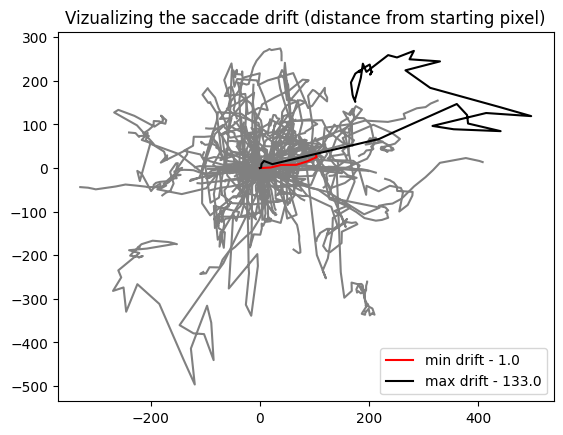

In [14]:
"""
Vizualizing the saccades drift
"""
min_drift = math.inf
max_drift = -math.inf
min_drift_id = 0
max_drift_id = 0
for saccade in df['saccade id'].unique():
    ewm_span = 500
    if (saccade != saccade) or saccade == None:
        continue
    temp = df[df['saccade id'] == saccade].copy()
    temp.reset_index(drop=True, inplace=True)
    baseline_x = temp['gaze x [px]'][0]
    temp['gaze x [px]'] = temp['gaze x [px]'] - baseline_x
    #temp['gaze x [px]'] = (temp['gaze x [px]']).ewm(span=ewm_span).mean()

    baseline_y = temp['gaze y [px]'][0]
    temp['gaze y [px]'] = temp['gaze y [px]'] - baseline_y
    #temp['gaze y [px]'] = temp['gaze y [px]'].ewm(span=ewm_span).mean()

    distance_list = [math.dist((0, 0), (x, y)) for x, y in zip(temp['gaze x [px]'], temp['gaze y [px]'])]

    if min(distance_list) < min_drift:
        min_drift = min(distance_list)
        min_drift_id = saccade
    
    if max(distance_list) > max_drift:
        max_drift = max(distance_list)
        max_drift_id = saccade

    x = [x for x in range(len(temp['gaze x [px]']))]
    plt.plot(temp['gaze y [px]'], temp['gaze x [px]'], color='grey')

plt.title('Vizualizing the saccade drift (distance from starting pixel)')
temp = df[df['saccade id'] == min_drift_id]
temp.shape
temp.reset_index(drop=True, inplace=True)
baseline_x = temp['gaze x [px]'][0]
temp['gaze x [px]'] = temp['gaze x [px]'] - baseline_x
temp['gaze x [px]'] = abs(temp['gaze x [px]'])

baseline_y = temp['gaze y [px]'][0]
temp['gaze y [px]'] = temp['gaze y [px]'] - baseline_y
temp['gaze y [px]'] = abs(temp['gaze y [px]'])
plt.plot(temp['gaze x [px]'], temp['gaze y [px]'], color='red', label=f'min drift - {min_drift_id}')

temp = df[df['saccade id'] == max_drift_id]
temp.reset_index(drop=True, inplace=True)
baseline_x = temp['gaze x [px]'][0]
temp['gaze x [px]'] = temp['gaze x [px]'] - baseline_x
temp['gaze x [px]'] = abs(temp['gaze x [px]'])

baseline_y = temp['gaze y [px]'][0]
temp['gaze y [px]'] = temp['gaze y [px]'] - baseline_y
temp['gaze y [px]'] = abs(temp['gaze y [px]'])
plt.plot(temp['gaze x [px]'], temp['gaze y [px]'], color='black', label=f'max drift - {max_drift_id}')

plt.legend()
plt.show()

In [ ]:
"""
Questions/Observations: 
1. How to compare 'amplitude' of fixations/saccades across multiple participants due to difference in prespective? 
For someone standing close by, one pixel could be an inch, but for someone far away, one pixel could be 6 inches
How does this impact the definition of a fixation/saccade? (by us or by pupil invisible)

2. OpenCV frames are processed in 50 millisecond increments, while the rows seem to be ~5 ms. 

3. There appear to be 133 fixations, but 124 saccades (which seems like a bug) in the new gaze.csv file

4. How to determine spatial similarity for the saccades/fixations? Is it from the staring point or from the previous gaze point? 

5. Would comparing the distributions and mean statistics count towards QC? 


"""